## Imports

In [151]:
from inspect import signature
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score, matthews_corrcoef,
                             precision_score, recall_score)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff


## Data Load


In [152]:
x_df = pd.read_csv('../data/features5.csv')
# x_df.drop(columns=['avg_stickied'], inplace=True)
y_df = pd.read_csv('../data/labels.csv')

display(x_df.head())
display(y_df.head())
x_df.shape, y_df.shape, x_df.columns, y_df.columns

username  link_karma  comment_karma  account_age is_verified  \
0           yakfsh1     19830.0        88232.0       1440.0        True   
1         Tsquare43    699100.0       720902.0       3636.0        True   
2      SeaSpeakToMe       236.0        11628.0       1029.0        True   
3    hurtingxliving       848.0         1275.0       2001.0        True   
4  Minute-Photo6916         1.0            4.0         12.0        True   

   avg_cosine_similarity  all_users_similarity  avg_comment_length  \
0                    1.0              0.019249              368.00   
1                    1.0              0.015121               62.00   
2                    NaN              0.012001               90.25   
3                    NaN              0.014932               37.00   
4                    NaN              0.008529               15.00   

   max_comment_length  min_comment_length  comment_post_ratio  \
0               368.0               368.0                 1.0   
1                62.0                62.0                 1.0   
2               141.0                64.0                 1.0   
3                37.0                37.0                 1.0   
4                15.0                15.0                 1.0   

   avg_thread_depth  parent_child_similarity   avg_ttr  \
0          0.666667                 0.030395  0.955981   
1          1.619048                 0.037736  0.955845   
2          1.000000                 0.121246  1.000000   
3          0.000000                 0.000000  0.888889   
4          1.000000                 0.000000  1.000000   

   avg_flesch_kincaid_grade  ngram_overlap    avg_score  avg_num_replies  
0                   9.20000       0.002070  1173.666667         2.111111  
1                   7.07619       0.000198    26.571429         0.333333  
2                   1.30000       0.000000     3.000000         0.000000  
3                  12.60000       0.000000     6.000000         0.000000  
4                  -2.30000       0.000000     5.000000         0.000000

username  is_bot
0           yakfsh1   False
1         Tsquare43   False
2      SeaSpeakToMe   False
3    hurtingxliving   False
4  Minute-Photo6916   False

((319174, 18),
 (319174, 2),
 Index(['username', 'link_karma', 'comment_karma', 'account_age', 'is_verified',
        'avg_cosine_similarity', 'all_users_similarity', 'avg_comment_length',
        'max_comment_length', 'min_comment_length', 'comment_post_ratio',
        'avg_thread_depth', 'parent_child_similarity', 'avg_ttr',
        'avg_flesch_kincaid_grade', 'ngram_overlap', 'avg_score',
        'avg_num_replies'],
       dtype='object'),
 Index(['username', 'is_bot'], dtype='object'))

In [153]:
y_df['is_bot'].value_counts()

is_bot
False    310526
True       8648
Name: count, dtype: int64

In [154]:
x_df = x_df.sort_values(by='username', ignore_index=True)
y_df = y_df.sort_values(by='username', ignore_index=True)

In [155]:
x_bot, y_bot = x_df[y_df['is_bot']].copy().reset_index(drop=True), y_df[y_df['is_bot']].copy().reset_index(drop=True)
x_user, y_user = x_df[~y_df['is_bot']].copy().reset_index(drop=True), y_df[~y_df['is_bot']].copy().reset_index(drop=True)

rand_state = 417
non_bot_multiplier = 2

x_user = x_user.sample(n=int(x_bot.shape[0] * non_bot_multiplier), random_state=rand_state).reset_index(drop=True)
y_user = y_user[y_user['username'].isin(x_user['username'])].reset_index(drop=True)

display(x_bot.shape, y_bot['is_bot'].value_counts()), display(x_user.shape, y_user['is_bot'].value_counts())


(8648, 18)

is_bot
True    8648
Name: count, dtype: int64

(17296, 18)

is_bot
False    17296
Name: count, dtype: int64

(None, None)

## Data preprocessing


In [156]:
def drop_columns(X, columns):
    return X.drop(columns, axis=1)


def replace_none(X, column_value_pairs):
    for column, value in column_value_pairs.items():
        X.loc[:, column] = X[column].fillna(value).infer_objects(copy=False)
    return X

def convert_bool(X, columns):
    for column in columns:
        X.loc[:, column] = X[column].apply(lambda x: 1 if x else 0)
    return X


def drop_rows_with_none(X, columns):
    return X.dropna(subset=columns)


In [157]:
class CustomStandardizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_standardize):
        self.columns_to_standardize = columns_to_standardize
        self.standard_scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='constant', fill_value=1)

    def fit(self, X, y=None):
        X = X.copy()
        without_none = X.dropna(subset=self.columns_to_standardize)
        self.standard_scaler.fit(without_none[self.columns_to_standardize])
        self.imputer.fit(X[self.columns_to_standardize])
        return self

    def transform(self, X, y=None):
        without_none = X.dropna(subset=self.columns_to_standardize)
        with_none = X[~X.index.isin(without_none.index)]
        X_standardized = self.standard_scaler.transform(without_none[self.columns_to_standardize])
        X_combined = np.hstack([X_standardized, without_none.drop(columns=self.columns_to_standardize, axis=1)])
        X_combined_df = pd.DataFrame(X_combined, index=without_none.index, columns=list(self.columns_to_standardize) + list(without_none.drop(columns=self.columns_to_standardize, axis=1).columns))
        X_final = pd.concat([X_combined_df, with_none], axis=0).sort_index()
        X_final[self.columns_to_standardize] = self.imputer.transform(X_final[self.columns_to_standardize])
        return X_final

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, outlier_columns, contamination=0.01):
        self.outlier_columns = outlier_columns
        self.contamination = contamination
        self.clf = IsolationForest(n_estimators=100, contamination=self.contamination, random_state=42)

    def fit(self, X, y=None):
        X_copy = X[self.outlier_columns].copy()
        self.clf.fit(X_copy)
        return self

    def transform(self, X, y=None):
        X_copy = X[self.outlier_columns].copy()
        outliers = self.clf.predict(X_copy)
        mask = outliers == 1
        if y is None:
            return X[mask]
        else:
            return X[mask], y.loc[X[mask].index]
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X, y)


class CustomColumnTransformer(ColumnTransformer):
    def fit(self, X, y=None):
        if isinstance(X, tuple):
            X, y = X
        result = super().fit(X, y)
        return result, y

    def transform(self, X, y=None):
        y = None
        if isinstance(X, tuple):
            X, y = X
        result = super().transform(X)
        return result, y

    def fit_transform(self, X, y=None):
        if isinstance(X, tuple):
            X, y = X
        result = super().fit_transform(X, y)
        return result, y

In [158]:
columns_to_drop = ["username"]
to_standardization = [
    "avg_comment_length",
    "max_comment_length",
    "min_comment_length",
    "avg_flesch_kincaid_grade",
    "link_karma",
    "comment_karma",
    "account_age",
    "is_verified",
    "avg_score",
    "avg_num_replies",
]
columns_to_standardize_before_replace = [
    "comment_post_ratio",
]
columns_to_replace_none = {
    'avg_cosine_similarity': 0,
    'all_users_similarity': 0,
    'avg_thread_depth': 0,
    'avg_ttr': 0,
    'ngram_overlap': 0,
    "avg_comment_length": 0,
    "max_comment_length": 0,
    "min_comment_length": 0,
    "avg_flesch_kincaid_grade": 0,
    "link_karma": 0,
    "comment_karma": 0,
    "comment_post_ratio": 0,
    "account_age": 0,
    "is_verified": 0,
    "parent_child_similarity": 0,
    "avg_score": 0,
    "avg_num_replies": 0
}
columns_to_drop_none = [
    'link_karma',
    'comment_karma',
    'account_age',
    'is_verified',
]
columns_to_convert_bool = [
    'is_verified',
]
to_remove_outliers = [
    'link_karma',
    'comment_karma',
    "avg_comment_length",
    "max_comment_length",
    "min_comment_length",
]

In [159]:
none_transformer = Pipeline(
    steps=[
        ('drop_columns', FunctionTransformer(drop_columns, kw_args={'columns': columns_to_drop})),
        ('drop_rows_with_none', FunctionTransformer(drop_rows_with_none, kw_args={'columns': columns_to_drop_none})),
        ('convert_bool', FunctionTransformer(convert_bool, kw_args={'columns': columns_to_convert_bool})),
        ('replace_none_without_std', FunctionTransformer(replace_none, kw_args={'column_value_pairs': columns_to_replace_none})),
    ]
)

column_preprocessor = CustomColumnTransformer(
    transformers=[
        ('standardization', StandardScaler(), to_standardization),
        ('std_before_replace', CustomStandardizer(columns_to_standardize_before_replace), columns_to_standardize_before_replace),
    ], remainder='passthrough'
)

In [160]:
class CustomPipeline(Pipeline):
    def transform(self, X, y=None, **transform_params):
        Xt = X
        for _, name, transform in self._iter(with_final=False):
            if hasattr(transform, "transform"):
                # Check if transform accepts y as a parameter
                sig = signature(transform.transform)
                if "y" in sig.parameters:
                    Xt = transform.transform(Xt, y=y, **transform_params)
                else:
                    Xt = transform.transform(Xt, **transform_params)
        return Xt

In [161]:
preprocessing_pipeline = CustomPipeline(
    steps=[
        ('none_transformer', none_transformer),
        ('outlier_remover', OutlierRemover(to_remove_outliers)),
        ('column_preprocessor', column_preprocessor),
    ]
)

In [162]:
_ = preprocessing_pipeline.fit(x_df, pd.DataFrame(y_df['is_bot']))
X_user_preprocessed, y_user_preprocessed = preprocessing_pipeline.transform(x_user, pd.DataFrame(y_user['is_bot']))
X_bot_preprocessed, y__botpreprocessed = preprocessing_pipeline.transform(x_bot, pd.DataFrame(y_bot['is_bot']))

/tmp/ipykernel_51251/3790178958.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, column] = X[column].fillna(value).infer_objects(copy=False)
/tmp/ipykernel_51251/3790178958.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, column] = X[column].fillna(value).infer_objects(copy=False)
/tmp/ipykernel_51251/3790178958.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.se

## Plotly feature distribution

In [163]:
x_bot_prepr_df = pd.DataFrame(X_bot_preprocessed, columns=x_df.columns[1:])
x_user_prepr_df = pd.DataFrame(X_user_preprocessed, columns=x_df.columns[1:])

x_bot_prepr_df['is_bot'] = 1
x_user_prepr_df['is_bot'] = 0

merged_df = pd.concat([x_bot_prepr_df, x_user_prepr_df], axis=0, ignore_index=True)

numeric_columns = merged_df.select_dtypes(include=['number']).columns[:-1]

display(x_bot_prepr_df.head(5), x_bot_prepr_df.shape)
display(x_user_prepr_df.head(5), x_user_prepr_df.shape)

link_karma  comment_karma  account_age is_verified  avg_cosine_similarity  \
0     10841.0         8020.0        103.0           1                    1.0   
1       665.0         3589.0       4383.0           1                    0.0   
2     36236.0       303465.0       3437.0           1                    1.0   
3       189.0         8577.0       1688.0           1                    1.0   
4      4037.0         4130.0       1944.0           1                    1.0   

   all_users_similarity  avg_comment_length  max_comment_length  \
0              0.026039           27.000000                41.0   
1              0.008800           43.416667               126.0   
2              0.036178          176.000000               176.0   
3              0.032791           98.000000                98.0   
4              0.034878          342.666667               361.0   

   min_comment_length  comment_post_ratio  avg_thread_depth  \
0                17.0                 1.0          3.080000   
1                 8.0                 1.0          0.000000   
2               176.0                 1.0          1.153846   
3                98.0                 1.0          2.000000   
4               307.0                 1.0          2.200000   

   parent_child_similarity   avg_ttr  avg_flesch_kincaid_grade  ngram_overlap  \
0                 0.068125  0.928119                 15.744000       0.001204   
1                 0.000000  1.000000                 45.000000       0.000000   
2                 0.084436  0.846640                 28.107692       0.004979   
3                 0.086850  0.777778                 30.266667       0.973154   
4                 0.114869  0.793880                 26.600000       0.001721   

   avg_score  avg_num_replies  is_bot  
0  33.920000         1.160000       1  
1   1.000000         0.000000       1  
2   3.846154         0.153846       1  
3  -5.000000         1.000000       1  
4  -2.800000         1.200000       1

(7481, 18)

link_karma  comment_karma  account_age is_verified  avg_cosine_similarity  \
0       357.0        50666.0       4688.0           1                    0.0   
1      2601.0        75504.0       4394.0           1                    1.0   
3      1373.0        20887.0       5078.0           1                    0.0   
4      3756.0         2258.0       1146.0           1                    0.0   
5     12783.0         4597.0       4609.0           1                    0.0   

   all_users_similarity  avg_comment_length  max_comment_length  \
0              0.048559          315.500000               856.0   
1              0.020935          223.000000               223.0   
3              0.013807          187.000000               290.0   
4              0.005541           48.666667               120.0   
5              0.020314          102.500000               115.0   

   min_comment_length  comment_post_ratio  avg_thread_depth  \
0               106.0                 1.0               4.0   
1               223.0                 1.0               2.0   
3                84.0                 1.0               3.0   
4                11.0                 1.0               0.0   
5                90.0                 1.0               2.0   

   parent_child_similarity   avg_ttr  avg_flesch_kincaid_grade  ngram_overlap  \
0                 0.048858  0.734940                     32.10            0.0   
1                 0.072973  1.000000                      8.35            0.0   
3                 0.100629  1.000000                      2.50            0.0   
4                 0.000000  1.000000                      6.40            0.0   
5                 0.149460  0.857143                     13.40            0.0   

   avg_score  avg_num_replies  is_bot  
0       52.0              0.0       0  
1       21.5              0.5       0  
3        5.0              0.0       0  
4        1.0              0.0       0  
5       32.0              0.0       0

(14990, 18)

In [164]:
merged_df.dtypes

link_karma                  float64
comment_karma               float64
account_age                 float64
is_verified                  object
avg_cosine_similarity       float64
all_users_similarity        float64
avg_comment_length          float64
max_comment_length          float64
min_comment_length          float64
comment_post_ratio          float64
avg_thread_depth            float64
parent_child_similarity     float64
avg_ttr                     float64
avg_flesch_kincaid_grade    float64
ngram_overlap               float64
avg_score                   float64
avg_num_replies             float64
is_bot                        int64
dtype: object

In [165]:
display(x_bot_prepr_df.describe())
display(x_user_prepr_df.describe())

link_karma  comment_karma  account_age  avg_cosine_similarity  \
count  7.481000e+03   7.481000e+03  7481.000000            7481.000000   
mean   8.832096e+03   5.700574e+04  2443.567571               0.543510   
std    6.252203e+04   1.232205e+05  1617.157805               0.498137   
min    1.000000e+00  -9.100000e+01     2.000000               0.000000   
25%    6.400000e+01   3.105000e+03  1026.000000               0.000000   
50%    7.310000e+02   1.605800e+04  2348.000000               1.000000   
75%    4.356000e+03   5.750300e+04  3785.000000               1.000000   
max    3.026310e+06   2.499886e+06  6870.000000               1.000000   

       all_users_similarity  avg_comment_length  max_comment_length  \
count           7481.000000         7481.000000         7481.000000   
mean               0.023844          120.943755          266.548322   
std                0.013623          123.290130          358.025973   
min                0.000000            0.000000            0.000000   
25%                0.015131           41.625000           55.000000   
50%                0.023292           82.333333          142.000000   
75%                0.031218          158.000000          334.000000   
max                0.095166         1408.400000         4162.000000   

       min_comment_length  comment_post_ratio  avg_thread_depth  \
count         7481.000000         7481.000000       7481.000000   
mean            56.225906            1.264715          1.750028   
std             87.491754            4.183830          1.665638   
min              0.000000            0.000000          0.000000   
25%             11.000000            1.000000          0.000000   
50%             26.000000            1.000000          1.400000   
75%             62.000000            1.000000          2.857143   
max            879.000000          258.000000          9.000000   

       parent_child_similarity      avg_ttr  avg_flesch_kincaid_grade  \
count              7481.000000  7481.000000               7481.000000   
mean                  0.052268     0.880274                 24.443926   
std                   0.064300     0.153291                 35.118593   
min                   0.000000     0.000000                -15.700000   
25%                   0.000000     0.840206                  8.900000   
50%                   0.035214     0.911651                 16.193333   
75%                   0.082521     0.984794                 27.128571   
max                   1.000000     1.000000                663.700000   

       ngram_overlap    avg_score  avg_num_replies  is_bot  
count    7481.000000  7481.000000      7481.000000  7481.0  
mean        0.004768    53.663735         0.613241     1.0  
std         0.044068   222.007007         0.966148     0.0  
min         0.000000   -81.500000         0.000000     1.0  
25%         0.000000     2.000000         0.000000     1.0  
50%         0.000000     8.666667         0.333333     1.0  
75%         0.001584    30.800000         1.000000     1.0  
max         1.000000  5300.000000        15.000000     1.0

link_karma  comment_karma   account_age  avg_cosine_similarity  \
count   14990.000000   1.499000e+04  14990.000000           14990.000000   
mean     4701.176785   3.367237e+04   2149.983923               0.378786   
std     18691.274254   7.613414e+04   1548.375902               0.485101   
min         1.000000  -1.000000e+02      0.000000               0.000000   
25%        28.000000   1.317000e+03    786.000000               0.000000   
50%       427.500000   8.543000e+03   1924.000000               0.000000   
75%      2833.500000   3.318550e+04   3390.000000               1.000000   
max    732344.000000   2.471551e+06   6924.000000               1.000000   

       all_users_similarity  avg_comment_length  max_comment_length  \
count          14990.000000        14990.000000        14990.000000   
mean               0.020052          126.715470          283.819680   
std                0.013065          128.396639          394.309623   
min                0.000000            0.000000            0.000000   
25%                0.010803           42.974138           58.000000   
50%                0.019316           88.500000          157.000000   
75%                0.028004          165.666667          353.000000   
max                0.092317         1408.400000         7276.000000   

       min_comment_length  comment_post_ratio  avg_thread_depth  \
count        14990.000000        14990.000000      14990.000000   
mean            58.308672            0.989648          1.195988   
std             92.625447            0.858261          1.520154   
min              0.000000            0.000000          0.000000   
25%             11.000000            1.000000          0.000000   
50%             26.000000            1.000000          1.000000   
75%             63.000000            1.000000          2.000000   
max            880.000000           56.000000          9.000000   

       parent_child_similarity       avg_ttr  avg_flesch_kincaid_grade  \
count             14990.000000  14990.000000              14990.000000   
mean                  0.041565      0.880336                 10.347742   
std                   0.071871      0.211808                 17.721055   
min                   0.000000      0.000000                -15.700000   
25%                   0.000000      0.861213                  2.900000   
50%                   0.000000      0.941176                  7.200000   
75%                   0.061964      1.000000                 13.029643   
max                   0.972454      1.000000               1389.000000   

       ngram_overlap     avg_score  avg_num_replies   is_bot  
count   14990.000000  14990.000000     14990.000000  14990.0  
mean        0.001581     50.530336         0.471554      0.0  
std         0.023071    319.395572         1.008377      0.0  
min         0.000000   -562.333333         0.000000      0.0  
25%         0.000000      1.000000         0.000000      0.0  
50%         0.000000      4.000000         0.000000      0.0  
75%         0.000000     17.000000         0.666667      0.0  
max         1.000000  15784.000000        21.000000      0.0

## Statistical tests

## Distribution tests

In [166]:
x_user = x_user.fillna(0)
x_bot = x_bot.fillna(0)

In [167]:
from scipy.stats import ks_2samp, anderson_ksamp

def dist_test(user, bot):
    res_distribs = {}
    for col in numeric_columns:
        
        ks_stat, ks_p_value = ks_2samp(user[col], bot[col])
        anderson = anderson_ksamp([user[col], bot[col]])
        res_distribs[col] = {
            'ks_stat': round(ks_stat, 3),
            'ks_p_value': round(ks_p_value, 5),
            'anderson_statistic': round(anderson.statistic, 3),
            'anderson_p_value': round(anderson.pvalue, 5),
            
        }
    return pd.DataFrame(res_distribs).T
display(dist_test(x_bot_prepr_df, x_user_prepr_df))
display(dist_test(x_user, x_bot))

/tmp/ipykernel_51251/1602365356.py:8: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson = anderson_ksamp([user[col], bot[col]])
/tmp/ipykernel_51251/1602365356.py:8: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson = anderson_ksamp([user[col], bot[col]])


ks_stat  ks_p_value  anderson_statistic  \
link_karma                  0.071     0.00000              97.768   
comment_karma               0.116     0.00000             282.796   
account_age                 0.077     0.00000             110.510   
avg_cosine_similarity       0.165     0.00000             722.852   
all_users_similarity        0.135     0.00000             274.476   
avg_comment_length          0.032     0.00006               7.974   
max_comment_length          0.034     0.00003               7.828   
min_comment_length          0.011     0.63148              -0.367   
comment_post_ratio          0.031     0.00012             282.404   
avg_thread_depth            0.189     0.00000             676.192   
parent_child_similarity     0.177     0.00000             570.680   
avg_ttr                     0.132     0.00000             291.013   
avg_flesch_kincaid_grade    0.363     0.00000            2065.155   
ngram_overlap               0.201     0.00000            1581.558   
avg_score                   0.145     0.00000             285.051   
avg_num_replies             0.183     0.00000             616.958   

                          anderson_p_value  
link_karma                           0.001  
comment_karma                        0.001  
account_age                          0.001  
avg_cosine_similarity                0.001  
all_users_similarity                 0.001  
avg_comment_length                   0.001  
max_comment_length                   0.001  
min_comment_length                   0.250  
comment_post_ratio                   0.001  
avg_thread_depth                     0.001  
parent_child_similarity              0.001  
avg_ttr                              0.001  
avg_flesch_kincaid_grade             0.001  
ngram_overlap                        0.001  
avg_score                            0.001  
avg_num_replies                      0.001

/tmp/ipykernel_51251/1602365356.py:8: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson = anderson_ksamp([user[col], bot[col]])
/tmp/ipykernel_51251/1602365356.py:8: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson = anderson_ksamp([user[col], bot[col]])


ks_stat  ks_p_value  anderson_statistic  \
link_karma                  0.067     0.00000              89.411   
comment_karma               0.106     0.00000             240.804   
account_age                 0.071     0.00000              97.095   
avg_cosine_similarity       0.167     0.00000             858.359   
all_users_similarity        0.138     0.00000             331.506   
avg_comment_length          0.032     0.00001               9.273   
max_comment_length          0.031     0.00004               7.753   
min_comment_length          0.011     0.50706              -0.089   
comment_post_ratio          0.032     0.00002             336.208   
avg_thread_depth            0.191     0.00000             786.320   
parent_child_similarity     0.181     0.00000             687.314   
avg_ttr                     0.135     0.00000             349.966   
avg_flesch_kincaid_grade    0.362     0.00000            2383.818   
ngram_overlap               0.206     0.00000            1894.474   
avg_score                   0.148     0.00000             345.127   
avg_num_replies             0.184     0.00000             719.535   

                          anderson_p_value  
link_karma                           0.001  
comment_karma                        0.001  
account_age                          0.001  
avg_cosine_similarity                0.001  
all_users_similarity                 0.001  
avg_comment_length                   0.001  
max_comment_length                   0.001  
min_comment_length                   0.250  
comment_post_ratio                   0.001  
avg_thread_depth                     0.001  
parent_child_similarity              0.001  
avg_ttr                              0.001  
avg_flesch_kincaid_grade             0.001  
ngram_overlap                        0.001  
avg_score                            0.001  
avg_num_replies                      0.001

### statistical tests for comparing groups

In [175]:
from scipy.stats import ttest_ind, mannwhitneyu

res_stat = {}
for col in numeric_columns:
    u_stat, u_p_value = mannwhitneyu(x_user_prepr_df[col], x_bot_prepr_df[col])
    t_stat, t_p_value = ttest_ind(x_user_prepr_df[col], x_bot_prepr_df[col])
    res_stat[col] = {
        'u_stat': round(u_stat, 3),
        'u_p_value': round(u_p_value, 5),
        't_stat': round(t_stat, 3),
        't_p_value': round(t_p_value, 5),
    }

display(pd.DataFrame(res_stat).T)
    
    

u_stat  u_p_value  t_stat  t_p_value
link_karma                50621050.5    0.00000  -7.450    0.00000
comment_karma             46657328.5    0.00000 -17.451    0.00000
account_age               50211252.0    0.00000 -13.196    0.00000
avg_cosine_similarity     46833984.0    0.00000 -23.774    0.00000
all_users_similarity      46746359.5    0.00000 -20.209    0.00000
avg_comment_length        57699729.0    0.00038   3.218    0.00129
max_comment_length        57661736.0    0.00051   3.189    0.00143
min_comment_length        56153071.0    0.85630   1.618    0.10573
comment_post_ratio        53682412.5    0.00000  -7.730    0.00000
avg_thread_depth          43698150.0    0.00000 -24.928    0.00000
parent_child_similarity   45993981.0    0.00000 -10.888    0.00000
avg_ttr                   63610672.5    0.00000   0.023    0.98188
avg_flesch_kincaid_grade  30816583.5    0.00000 -39.990    0.00000
ngram_overlap             44987791.5    0.00000  -7.114    0.00000
avg_score                 46959004.0    0.00000  -0.762    0.44627
avg_num_replies           46534844.5    0.00000 -10.064    0.00000

## PCA representation

In [233]:
from sklearn.decomposition import PCA

def plot_pca_3d(X, title='3D PCA'):
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X.drop(columns=['is_bot']).reset_index(drop=True))
    X_user_pca = pca.fit_transform(X[X['is_bot']==0].drop(columns=['is_bot']).reset_index(drop=True))
    X_bot_pca = pca.transform(X[X['is_bot']==1].drop(columns=['is_bot']).reset_index(drop=True))
    
    
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=X_user_pca[:, 0],
        y=X_user_pca[:, 1],
        z=X_user_pca[:, 2],
        mode='markers',
        marker=dict(size=5, color='yellow'),
        name=f'Users'
    ))
    fig.add_trace(go.Scatter3d(
        x=X_bot_pca[:, 0],
        y=X_bot_pca[:, 1],
        z=X_bot_pca[:, 2],
        mode='markers',
        marker=dict(size=5, color='purple'),
        name=f'Bots'
    ))
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='Principal Component 1',
            yaxis_title='Principal Component 2',
            zaxis_title='Principal Component 3'
        )
    )
    fig.update_layout(width=800, height=800) 
    fig.show()
    


def plot_pca_2d(X, title='2D PCA'):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    X_user_pca = pca.fit_transform(X[X['is_bot']==0].drop(columns=['is_bot']).reset_index(drop=True))
    X_bot_pca = pca.transform(X[X['is_bot']==1].drop(columns=['is_bot']).reset_index(drop=True))
    
    fig = go.Figure()
    # fig = px.scatter(X_pca, x=0, y=1, color=X['is_bot'].astype(str), title=title)
    fig.add_trace(go.Scatter(
        x=X_user_pca[:, 0],
        y=X_user_pca[:, 1],
        mode='markers',
        marker=dict(size=5, color='yellow'),
        name=f'Users'
    ))
    fig.add_trace(go.Scatter(
        x=X_bot_pca[:, 0],
        y=X_bot_pca[:, 1],
        mode='markers',
        marker=dict(size=5, color='purple'),
        name=f'Bots'
    ))
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='Principal Component 1',
            yaxis_title='Principal Component 2'
    ))
    
    
    fig.update_layout(width=800, height=600) 
    fig.show()

In [234]:
plot_pca_2d(merged_df, title='2D PCA of Training Data')
plot_pca_3d(merged_df,  title='3D PCA of Training Data')

### Other

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_distributions(X_train, y_train, class_column='is_bot'):
    y_train = y_train[class_column].values.flatten()
    
    # X_train = X_train.drop(columns=['username'])
    data = X_train.copy()
    # data[class_column] = y_train
    
    for feature in X_train.columns:
        try:
            plt.figure(figsize=(10, 6))
            sns.histplot(data=data, x=feature, hue=class_column, kde=True, bins=50, palette='viridis')
            plt.title(f'Distribution of {feature} by {class_column}')
            plt.xlabel(feature)
            plt.ylabel('Frequency')
            plt.legend(title=class_column)
            plt.show()
        except Exception as e:
            print(f"Error plotting {feature}: {e}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


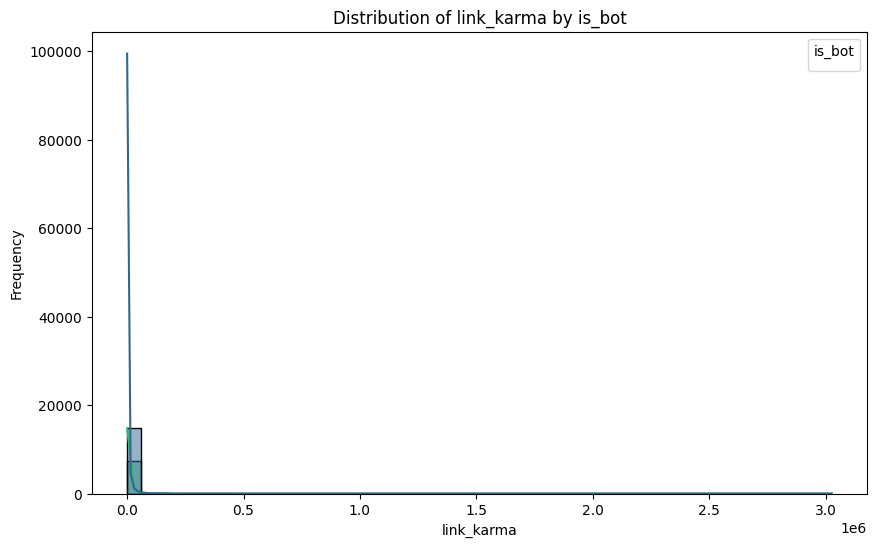

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


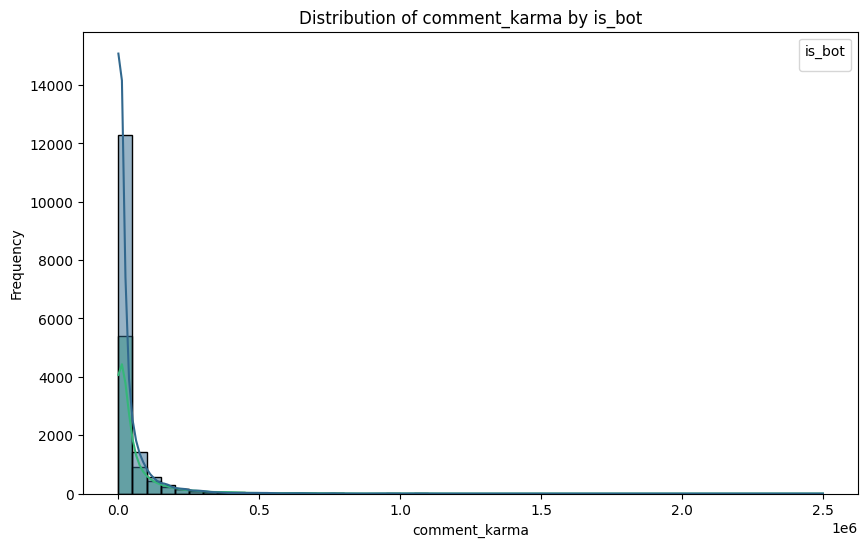

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


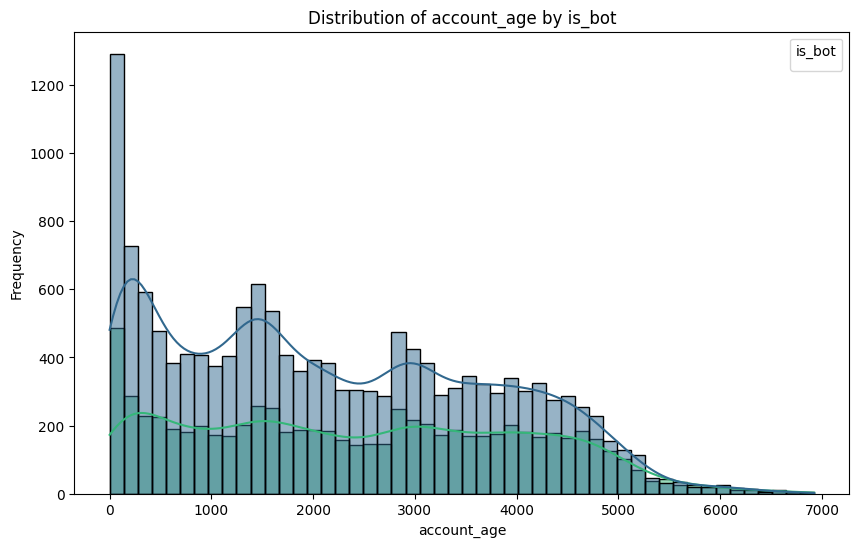

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


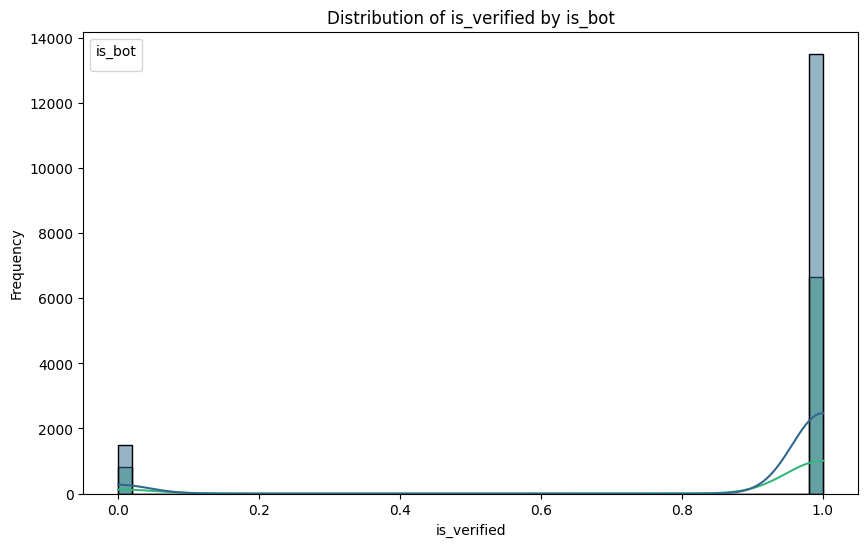

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


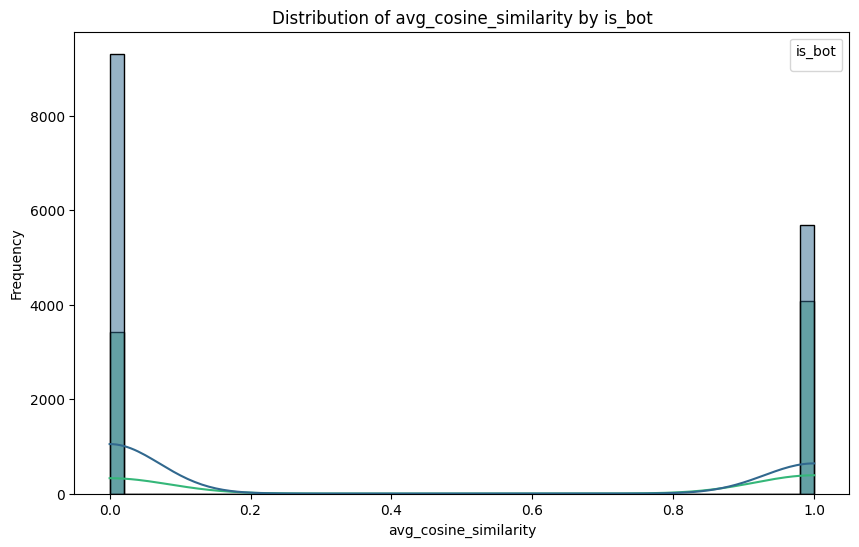

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


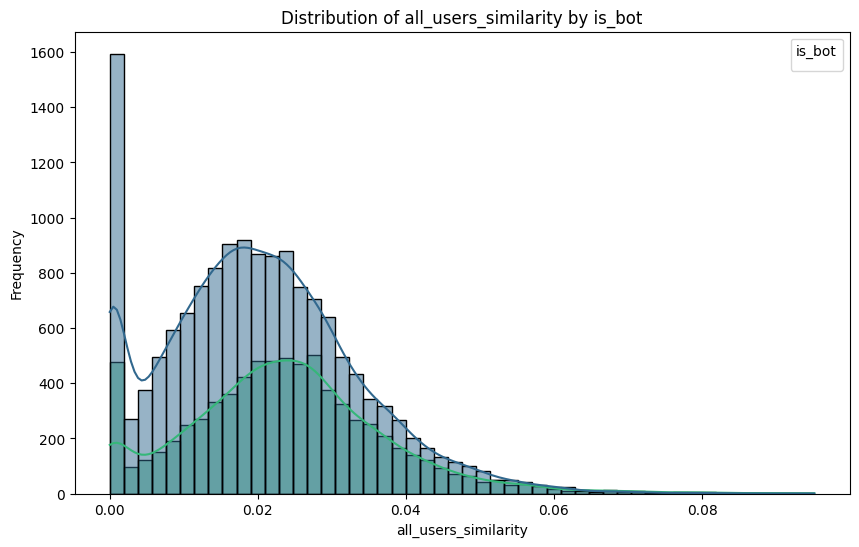

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


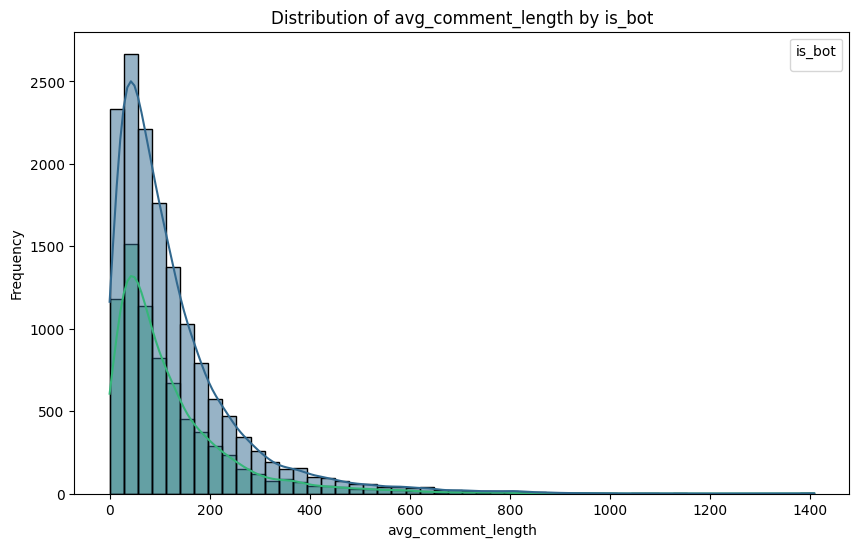

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


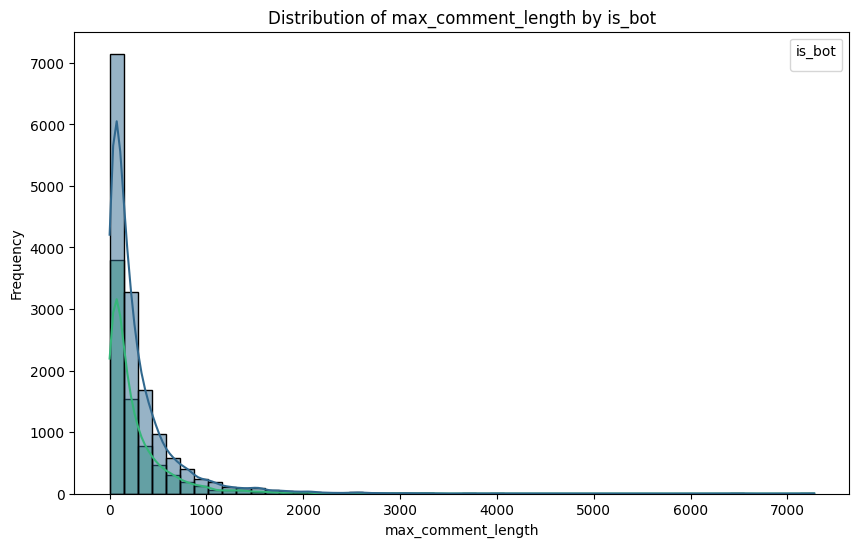

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


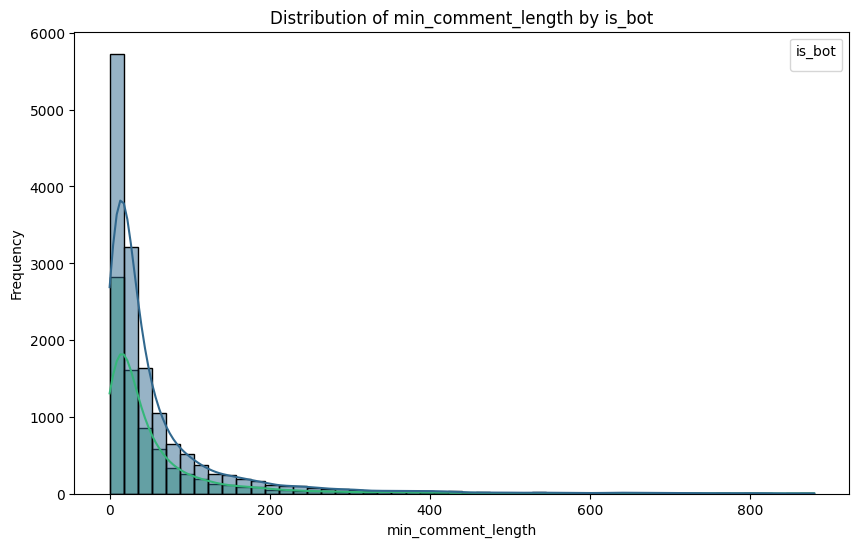

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


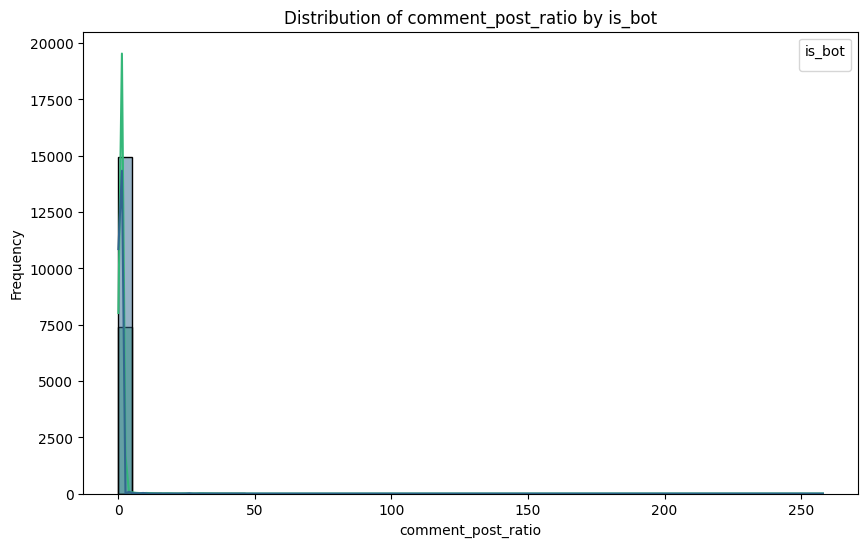

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


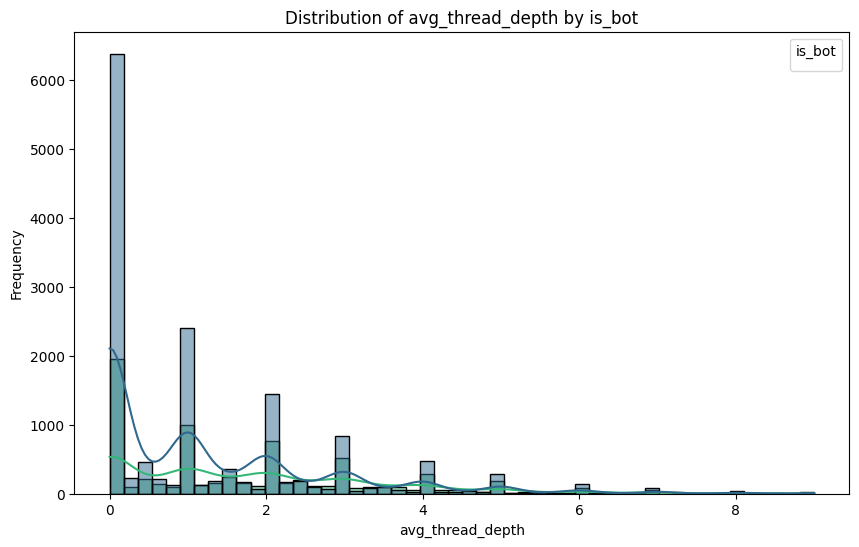

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


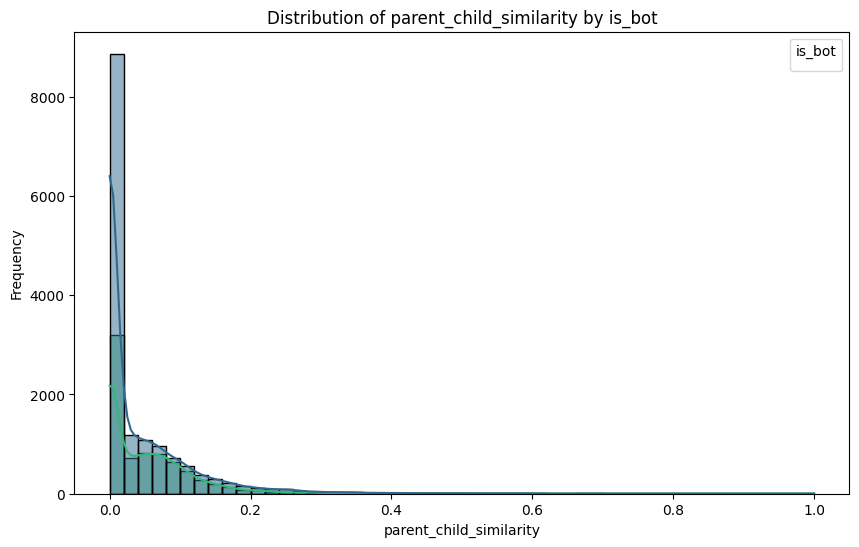

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


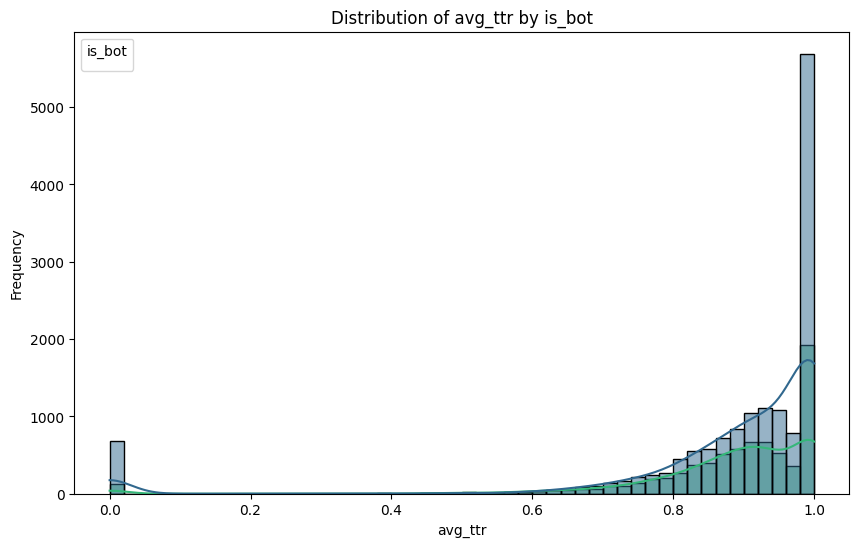

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


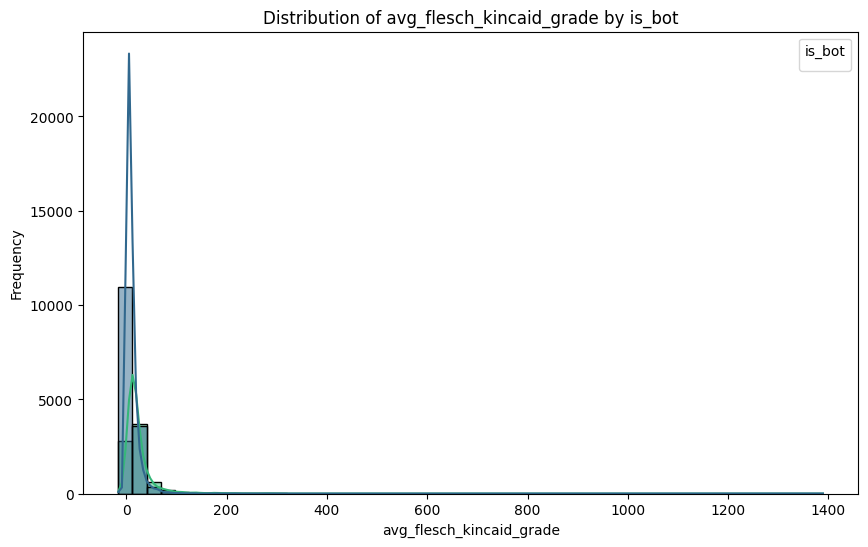

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


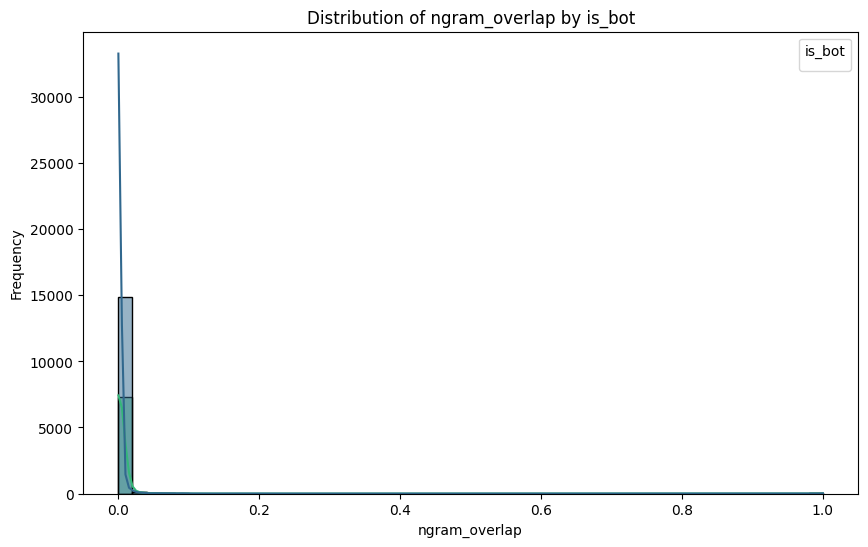

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


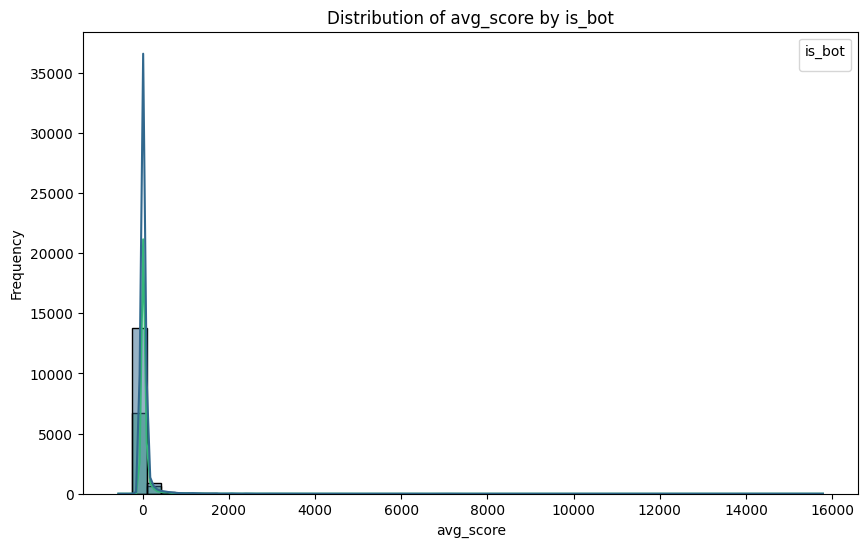

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


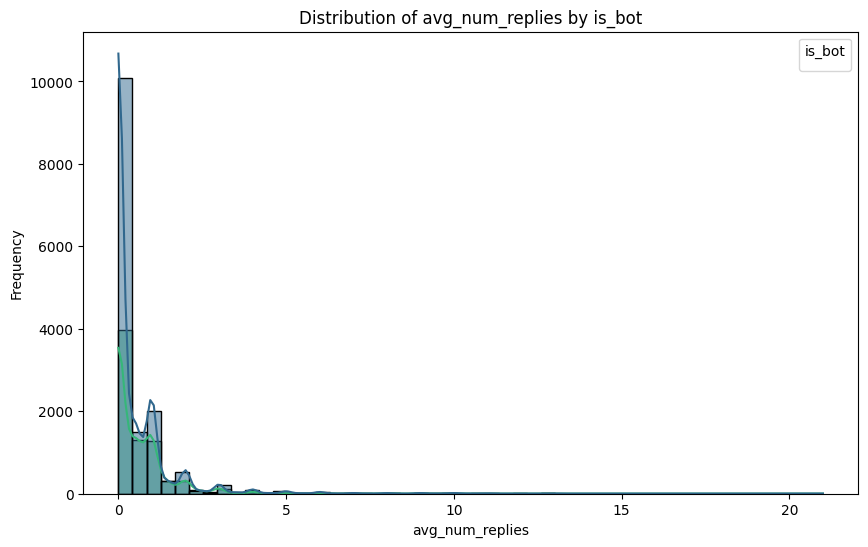

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


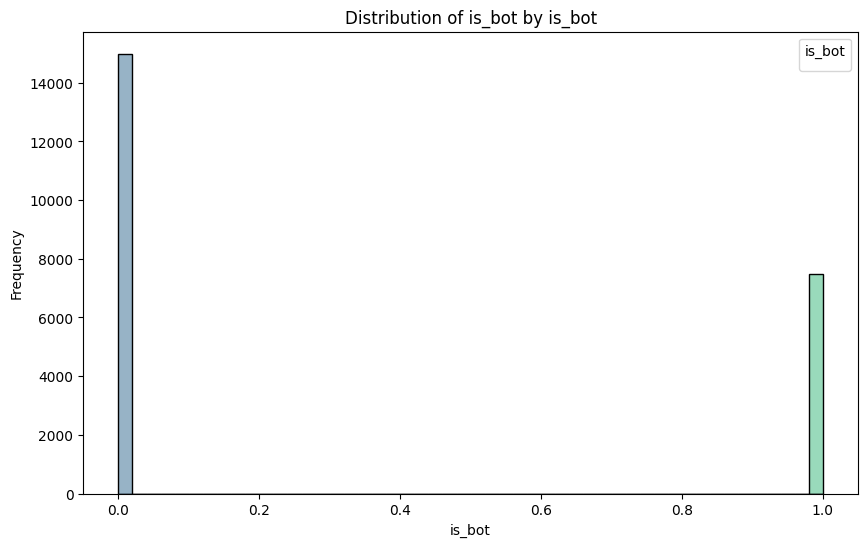

In [170]:
plot_feature_distributions(merged_df, y_df, class_column='is_bot')